In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, RandomHorizontalFlip
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
tensorShape = [112,112]
transforms = Compose([
                    ToTensor(),
                    Resize((tensorShape[0],tensorShape[1])),
                    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
])

In [ ]:
training_data_cifar10 = CIFAR10(
    root="CIFAR-10", 
    train=True, 
    download=True, 
    transform=transforms
)

test_data_cifar10 = CIFAR10(
    root="CIFAR-10",
    train=False,
    download=True,
    transform=transforms
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR-10/cifar-10-python.tar.gz to CIFAR-10
Files already downloaded and verified


In [ ]:
train_size = int(0.8 * len(training_data_cifar10))
val_size = len(training_data_cifar10) - train_size
train_dataset, val_dataset = random_split(training_data_cifar10, [train_size, val_size])


# A: linear tuning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V2

model_resnet50 = resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_resnet50.fc = nn.Linear(2048, 10)
model_resnet50 = model_resnet50.to(device)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_cifar10, batch_size=batch_size, shuffle=True)


In [ ]:
crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.0001)

model_resnet50.requires_grad_(False)
model_resnet50.fc.requires_grad_(True)


def train(model, train_loader, optimizer, loss_fn):
    train_losses = []
    accuracy = []   
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        accuracy.append((y_pred.argmax(1) == y).type(torch.float).sum().item())
        if batch % 100 == 0:
            print(f"Batch {batch} loss: {loss.item()}")
    accuracy = np.mean(accuracy)
    train_losses = np.mean(train_losses)
    return train_losses, accuracy


In [ ]:
def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            accuracy += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy /= len(test_loader.dataset)
    print("-------------------")
    print(f"Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")
    print("-------------------\n")
    return test_loss, accuracy


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet50_LinearTuning_Board')

epochs = 10
for t in range(epochs):
    print(f"-------------------------------")
    print(f"----------- Epoch {t} -----------")
    print(f"-------------------------------")
    train_loss, train_accuracy = train(model_resnet50, train_loader, optimizer, crossEntropyLoss)
    test_loss, test_accuracy = test(model_resnet50, test_loader, crossEntropyLoss)
    writer.add_scalar('Loss/train', np.mean(train_loss), t)
    writer.add_scalar('Loss/test', np.mean(test_loss), t)
    writer.add_scalar('Accuracy/train', np.mean(train_accuracy), t)
    writer.add_scalar('Accuracy/test', np.mean(test_accuracy), t)


-------------------------------
----------- Epoch 0 -----------
-------------------------------
Batch 0 loss: 2.323164939880371
Batch 100 loss: 1.646859884262085
Batch 200 loss: 1.2742679119110107
Batch 300 loss: 1.0329499244689941
-------------------
Accuracy: 77.6%, Avg loss: 0.007947
-------------------

-------------------------------
----------- Epoch 1 -----------
-------------------------------
Batch 0 loss: 1.0819594860076904
Batch 100 loss: 0.8342183828353882
Batch 200 loss: 0.7395062446594238
Batch 300 loss: 0.8862619400024414
-------------------
Accuracy: 80.1%, Avg loss: 0.005889
-------------------

-------------------------------
----------- Epoch 2 -----------
-------------------------------
Batch 0 loss: 0.78764808177948
Batch 100 loss: 0.8798073530197144
Batch 200 loss: 0.6554306149482727
Batch 300 loss: 0.6741552352905273
-------------------
Accuracy: 81.2%, Avg loss: 0.005098
-------------------

-------------------------------
----------- Epoch 3 -----------
-------

In [ ]:
test_loss, test_accuracy = test(model_resnet50, test_loader, crossEntropyLoss)

-------------------
Accuracy: 84.2%, Avg loss: 0.003808
-------------------



In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred.extend(model_resnet50(X).argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=training_data_cifar10.classes))


              precision    recall  f1-score   support

    airplane       0.87      0.84      0.85      1000
  automobile       0.90      0.88      0.89      1000
        bird       0.84      0.82      0.83      1000
         cat       0.74      0.74      0.74      1000
        deer       0.79      0.78      0.79      1000
         dog       0.82      0.83      0.83      1000
        frog       0.84      0.89      0.86      1000
       horse       0.87      0.83      0.85      1000
        ship       0.86      0.90      0.88      1000
       truck       0.87      0.88      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



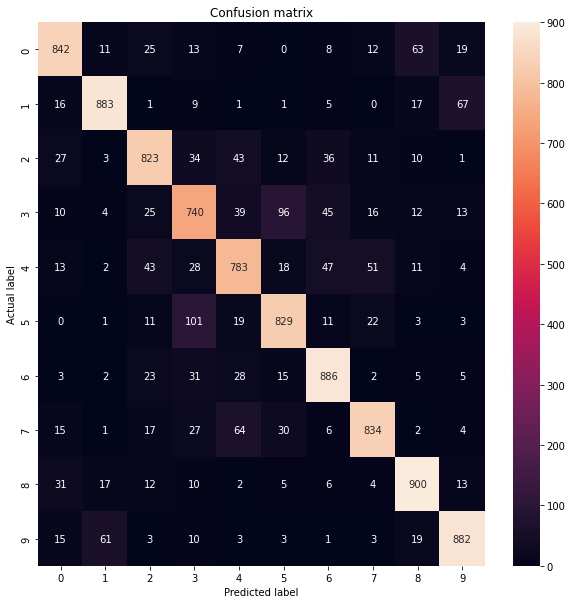

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
torch.save(model_resnet50.state_dict(), "ResNet50_LinearTuning.pt")

# B

In [ ]:
model_resnet18 = resnet18(weights=None)

model_resnet18.fc = nn.Linear(512, 10)
model_resnet18 = model_resnet18.to(device)   

In [ ]:
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, T, alpha):
        super(DistillationLoss, self).__init__()
        self.T = T
        self.alpha = alpha

    def forward(self, y, labels, teacher_scores):
        return self.alpha * nn.KLDivLoss()(F.log_softmax(y / self.T, dim=1),
                                           F.softmax(teacher_scores / self.T, dim=1)) + (1. - self.alpha) * nn.CrossEntropyLoss()(y, labels)

distillationLoss = DistillationLoss(T=20, alpha=0.5)

optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

def train_distillation(model, teacher_model, train_loader, optimizer, loss_fn):
    train_losses = []
    accuracy = []
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        student_scores = model(X)
        teacher_scores = teacher_model(X)
        train_loss = loss_fn(student_scores, y, teacher_scores)
        train_losses.append(train_loss.item())
        accuracy.append((student_scores.argmax(1) == y).type(torch.float).sum().item())
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Batch {batch} loss: {train_loss.item()}")
    accuracy = np.mean(accuracy)
    train_losses = np.mean(train_losses)
    return train_losses, accuracy


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet18_Distillation_Board')
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.0001)
epochs = 10
for t in range(epochs):
    print(f"-------------------------------")
    print(f"----------- Epoch {t} -----------")
    print(f"-------------------------------")
    train_loss, train_accuracy = train_distillation(model_resnet18, model_resnet50, train_loader, optimizer, distillationLoss)
    test_loss, test_accuracy = test(model_resnet18, test_loader, crossEntropyLoss)
    writer.add_scalar('Loss/train', np.mean(train_loss), t)
    writer.add_scalar('Loss/test', np.mean(test_loss), t)
    writer.add_scalar('Accuracy/train', np.mean(train_accuracy), t)
    writer.add_scalar('Accuracy/test', np.mean(test_accuracy), t)

-------------------------------
----------- Epoch 0 -----------
-------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Batch 0 loss: 1.2211740016937256
Batch 100 loss: 0.6921043992042542
Batch 200 loss: 0.6820911169052124
Batch 300 loss: 0.6181894540786743
-------------------
Accuracy: 59.3%, Avg loss: 0.008758
-------------------

-------------------------------
----------- Epoch 1 -----------
-------------------------------
Batch 0 loss: 0.48649176955223083
Batch 100 loss: 0.479624480009079
Batch 200 loss: 0.4931075870990753
Batch 300 loss: 0.4639156460762024
-------------------
Accuracy: 66.1%, Avg loss: 0.007495
-------------------

-------------------------------
----------- Epoch 2 -----------
-------------------------------
Batch 0 loss: 0.3167027533054352
Batch 100 loss: 0.32744458317756653
Batch 200 loss: 0.36957573890686035
Batch 300 loss: 0.3079836368560791
-------------------
Accuracy: 68.4%, Avg loss: 0.007208
-------------------

-------------------------------
----------- Epoch 3 -----------
-------------------------------
Batch 0 loss: 0.2429109811782837
Batch 100 loss: 0.14147971570491

In [ ]:
test_loss, test_accuracy = test(model_resnet18, test_loader, crossEntropyLoss)

-------------------
Accuracy: 68.1%, Avg loss: 0.011092
-------------------



In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        # to cpu
        y_pred.extend(model_resnet18(X).argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=training_data_cifar10.classes))


              precision    recall  f1-score   support

    airplane       0.68      0.74      0.70      1000
  automobile       0.82      0.80      0.81      1000
        bird       0.62      0.51      0.56      1000
         cat       0.50      0.44      0.47      1000
        deer       0.63      0.64      0.63      1000
         dog       0.56      0.61      0.59      1000
        frog       0.74      0.74      0.74      1000
       horse       0.68      0.73      0.71      1000
        ship       0.76      0.84      0.80      1000
       truck       0.79      0.74      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



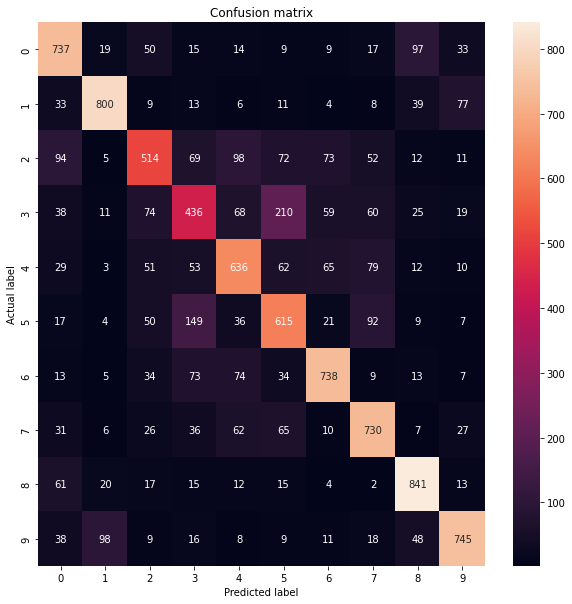

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
torch.save(model_resnet18.state_dict(), "ResNet18_Distillation.pt")


# C

In [ ]:
# weights = ResNet18_Weights.IMAGENET1K_V1
model_resnet18 = resnet18(weights=None)

model_resnet18.fc = nn.Linear(512, 10)
model_resnet18 = model_resnet18.to(device)


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet18_Board')
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.0001)
epochs = 10
for t in range(epochs):
    print(f"-------------------------------")
    print(f"----------- Epoch {t} -----------")
    print(f"-------------------------------")
    train_loss, train_accuracy = train(model_resnet18, train_loader, optimizer, crossEntropyLoss)
    test_loss, test_accuracy = test(model_resnet18, test_loader, crossEntropyLoss)
    writer.add_scalar('Loss/train', np.mean(train_loss), t)
    writer.add_scalar('Loss/test', np.mean(test_loss), t)
    writer.add_scalar('Accuracy/train', np.mean(train_accuracy), t)
    writer.add_scalar('Accuracy/test', np.mean(test_accuracy), t)

-------------------------------
----------- Epoch 0 -----------
-------------------------------
Batch 0 loss: 2.3241078853607178
Batch 100 loss: 1.3824387788772583
Batch 200 loss: 1.182045340538025
Batch 300 loss: 1.3415480852127075
-------------------
Accuracy: 58.1%, Avg loss: 0.009022
-------------------

-------------------------------
----------- Epoch 1 -----------
-------------------------------
Batch 0 loss: 1.0283676385879517
Batch 100 loss: 1.0429909229278564
Batch 200 loss: 0.8367665410041809
Batch 300 loss: 0.9474138617515564
-------------------
Accuracy: 64.9%, Avg loss: 0.007716
-------------------

-------------------------------
----------- Epoch 2 -----------
-------------------------------
Batch 0 loss: 0.5792322158813477
Batch 100 loss: 0.7316980361938477
Batch 200 loss: 0.9013291001319885
Batch 300 loss: 0.6981837749481201
-------------------
Accuracy: 66.5%, Avg loss: 0.007615
-------------------

-------------------------------
----------- Epoch 3 -----------
----

In [ ]:

test_loss, test_accuracy = test(model_resnet18, test_loader, crossEntropyLoss)

-------------------
Accuracy: 66.9%, Avg loss: 0.011415
-------------------



In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred.extend(model_resnet18(X).argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=training_data_cifar10.classes))

              precision    recall  f1-score   support

    airplane       0.68      0.74      0.71      1000
  automobile       0.80      0.80      0.80      1000
        bird       0.58      0.52      0.55      1000
         cat       0.47      0.43      0.45      1000
        deer       0.57      0.61      0.59      1000
         dog       0.57      0.64      0.60      1000
        frog       0.74      0.71      0.73      1000
       horse       0.72      0.70      0.71      1000
        ship       0.79      0.77      0.78      1000
       truck       0.77      0.74      0.76      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



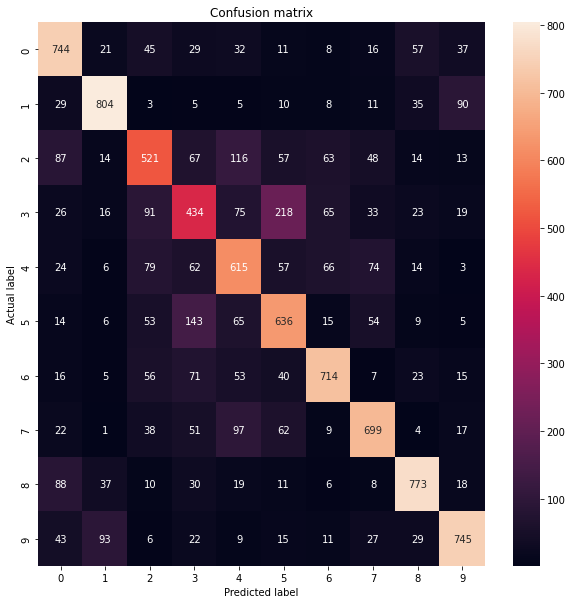

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
torch.save(model_resnet18.state_dict(), "model_resnet18.pt")

# D

In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V2
model_resnet50 = resnet50(weights=weights)
model_resnet50.fc = nn.Linear(2048, 10)
model_resnet50 = model_resnet50.to(device)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet50_Board')

optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.0001)
epochs = 10
for t in range(epochs):
    print(f"-------------------------------")
    print(f"----------- Epoch {t} -----------")
    print(f"-------------------------------")
    train_loss, train_accuracy = train(model_resnet50, train_loader, optimizer, crossEntropyLoss)
    test_loss, test_accuracy = test(model_resnet50, test_loader, crossEntropyLoss)
    writer.add_scalar('Loss/train', np.mean(train_loss), t)
    writer.add_scalar('Loss/test', np.mean(test_loss), t)
    writer.add_scalar('Accuracy/train', np.mean(train_accuracy), t)
    writer.add_scalar('Accuracy/test', np.mean(test_accuracy), t)

-------------------------------
----------- Epoch 0 -----------
-------------------------------
Batch 0 loss: 2.301443338394165
Batch 100 loss: 0.20564571022987366
Batch 200 loss: 0.2188454121351242
Batch 300 loss: 0.23416279256343842
-------------------
Accuracy: 94.7%, Avg loss: 0.001280
-------------------

-------------------------------
----------- Epoch 1 -----------
-------------------------------
Batch 0 loss: 0.03798776865005493
Batch 100 loss: 0.03438444435596466
Batch 200 loss: 0.044424671679735184
Batch 300 loss: 0.0678052082657814
-------------------
Accuracy: 95.0%, Avg loss: 0.001231
-------------------

-------------------------------
----------- Epoch 2 -----------
-------------------------------
Batch 0 loss: 0.02072654291987419
Batch 100 loss: 0.08088963478803635
Batch 200 loss: 0.019670885056257248
Batch 300 loss: 0.015209835954010487
-------------------
Accuracy: 95.0%, Avg loss: 0.001379
-------------------

-------------------------------
----------- Epoch 3 ----

In [ ]:

test_loss, test_accuracy = test(model_resnet50, test_loader, crossEntropyLoss)


-------------------
Accuracy: 95.1%, Avg loss: 0.001724
-------------------



In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        # to cpu
        y_pred.extend(model_resnet50(X).argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=training_data_cifar10.classes))

              precision    recall  f1-score   support

    airplane       0.97      0.96      0.97      1000
  automobile       0.97      0.96      0.97      1000
        bird       0.98      0.94      0.96      1000
         cat       0.92      0.86      0.89      1000
        deer       0.90      0.98      0.94      1000
         dog       0.90      0.92      0.91      1000
        frog       0.97      0.96      0.96      1000
       horse       0.97      0.97      0.97      1000
        ship       0.97      0.97      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



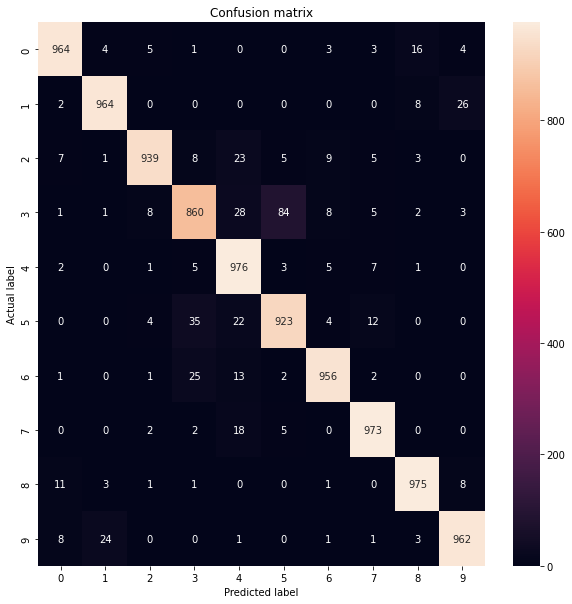

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
torch.save(model_resnet50.state_dict(), "model_resnet50.pt")

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
model_resnet18_full_tune = resnet18(weights=weights)
model_resnet18_full_tune.fc = nn.Linear(512, 10)
model_resnet18_full_tune = model_resnet18_full_tune.to(device)


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='ResNet18_Full_Tune_Board')

optimizer = torch.optim.Adam(model_resnet18_full_tune.parameters(), lr=0.0001)
epochs = 10

for t in range(epochs):
    print(f"-------------------------------")
    print(f"----------- Epoch {t} -----------")
    print(f"-------------------------------")
    train_loss, train_accuracy = train(model_resnet18_full_tune, train_loader, optimizer, crossEntropyLoss)
    test_loss, test_accuracy = test(model_resnet18_full_tune, test_loader, crossEntropyLoss)
    writer.add_scalar('Loss/train', np.mean(train_loss), t)
    writer.add_scalar('Loss/test', np.mean(test_loss), t)
    writer.add_scalar('Accuracy/train', np.mean(train_accuracy), t)
    writer.add_scalar('Accuracy/test', np.mean(test_accuracy), t)

-------------------------------
----------- Epoch 0 -----------
-------------------------------
Batch 0 loss: 2.356726884841919
Batch 100 loss: 0.4015102982521057
Batch 200 loss: 0.2880452573299408
Batch 300 loss: 0.2871376872062683
-------------------
Accuracy: 92.0%, Avg loss: 0.001885
-------------------

-------------------------------
----------- Epoch 1 -----------
-------------------------------
Batch 0 loss: 0.08161378651857376
Batch 100 loss: 0.054225243628025055
Batch 200 loss: 0.07862907648086548
Batch 300 loss: 0.06597954034805298
-------------------
Accuracy: 92.3%, Avg loss: 0.001816
-------------------

-------------------------------
----------- Epoch 2 -----------
-------------------------------
Batch 0 loss: 0.020205935463309288
Batch 100 loss: 0.02583598904311657
Batch 200 loss: 0.02011934667825699
Batch 300 loss: 0.01855284348130226
-------------------
Accuracy: 93.0%, Avg loss: 0.001917
-------------------

-------------------------------
----------- Epoch 3 ------

In [ ]:
test_loss, test_accuracy = test(model_resnet18_full_tune, test_loader, crossEntropyLoss)

-------------------
Accuracy: 91.9%, Avg loss: 0.002825
-------------------



In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred.extend(model_resnet18_full_tune(X).argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=training_data_cifar10.classes))


              precision    recall  f1-score   support

    airplane       0.91      0.95      0.93      1000
  automobile       0.95      0.96      0.95      1000
        bird       0.94      0.89      0.91      1000
         cat       0.88      0.81      0.84      1000
        deer       0.89      0.94      0.91      1000
         dog       0.85      0.89      0.87      1000
        frog       0.93      0.97      0.95      1000
       horse       0.96      0.93      0.95      1000
        ship       0.96      0.95      0.95      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



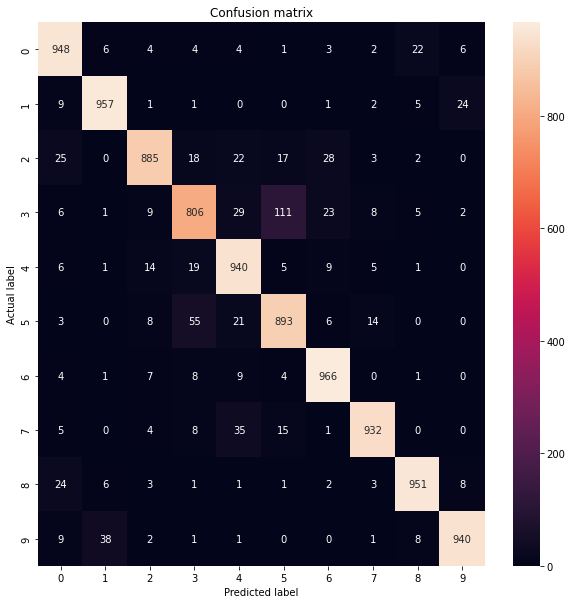

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
torch.save(model_resnet18_full_tune.state_dict(), "model_resnet18_full_tune.pt")

In [ ]:
!zip -r /content/sample_data.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.01.09/ (stored 0%)
  adding: content/.config/logs/2023.01.09/14.34.57.728355.log (deflated 53%)
  adding: content/.config/logs/2023.01.09/14.35.41.921526.log (deflated 53%)
  adding: content/.config/logs/2023.01.09/14.36.13.391200.log (deflated 54%)
  adding: content/.config/logs/2023.01.09/14.36.14.314176.log (deflated 54%)
  adding: content/.config/logs/2023.01.09/14.35.26.879372.log (deflated 86%)
  adding: content/.config/logs/2023.01.09/14.34.27.508072.log (deflated 91%)
  adding: content/.confi

In [40]:
!pwd

/content
